In [2]:
from __future__ import print_function, division
import numpy as np
import os
import pandas as pd
import zipfile
import geopandas as gp
from geopandas import GeoDataFrame
from fiona.crs import from_epsg
import sklearn as skl
from sklearn import preprocessing
from sklearn.cluster import KMeans
import pylab as pl
import scipy.cluster as scp
import json
import shapely
import scipy.stats
%matplotlib inline
import ast
import json

import urllib
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import io
from fiona.crs import from_epsg

try:
    from urllib.request import urlopen
    from urllib.parse import urlparse
except ImportError:
    from urlparse import urlparse
    from urllib2 import urlopen

%pylab inline

PUIDATA = os.getenv('PUIDATA')

Populating the interactive namespace from numpy and matplotlib


In [5]:
# downloading nonseven major felony offenses
url = "http://www.nyc.gov/html/nypd/downloads/excel/analysis_and_planning/\
citywide_historical_non_seven_major_felony_offenses_2000-2015.xls"
nonseven = pd.read_excel(url, header=3)

In [58]:
#downloading misdemeanor data
url2 = "http://www.nyc.gov/html/nypd/downloads/excel/analysis_and_planning/\
misdemeanor_offenses_listing_2000_2015.xls"
misde = pd.read_excel(url2, header=3)

,OFFENSE,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,MISDEMEANOR POSSESSION OF STOLEN PROPERTY,1072.0,1382.0,1577.0,1781.0,1853.0,1827.0,2009.0,1880.0,1811.0,2023.0,2240.0,2853.0,2662.0,2337.0,1469.0,1145.0
1,MISDEMEANOR SEX CRIMES (4),4394.0,4584.0,4218.0,3978.0,4019.0,3937.0,4803.0,4393.0,4289.0,4459.0,4512.0,4632.0,4480.0,4064.0,4246.0,4555.0
2,MISDEMEANOR DANGEROUS DRUGS (1),96590.0,75766.0,77048.0,70185.0,59671.0,61076.0,65945.0,77212.0,76286.0,79302.0,79908.0,80462.0,67898.0,55529.0,52835.0,38471.0
3,MISDEMEANOR DANGEROUS WEAPONS (5),3387.0,3718.0,4056.0,4651.0,5173.0,6170.0,7097.0,7734.0,7654.0,8367.0,8716.0,8601.0,7136.0,6522.0,6166.0,5685.0
4,PETIT LARCENY,93785.0,92941.0,90456.0,85494.0,84047.0,82131.0,81031.0,80237.0,83113.0,80928.0,81522.0,81160.0,82947.0,85602.0,85121.0,81598.0


In [3]:
#downloading misdemeanor by precinct
url3 = 'http://www.nyc.gov/html/nypd/downloads/excel/analysis_and_planning/\
misdemeanor_offenses_listing_by_precinct_2000-2015.xls'
misde_prec = pd.read_excel(url3, header=2)

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,1,MISDEMEANOR POSSESSION OF STOLEN PROPERTY ...,6.0,16.0,7.0,11.0,7.0,18.0,13.0,14.0,25.0,19.0,34.0,33.0,42.0,43.0,37.0,18.0
1,NaN,MISDEMEANOR SEX CRIMES (4),43.0,47.0,38.0,38.0,32.0,25.0,32.0,26.0,25.0,31.0,27.0,50.0,44.0,42.0,43.0,35.0
2,NaN,MISDEMEANOR DANGEROUS DRUGS (1),453.0,438.0,330.0,219.0,86.0,42.0,50.0,38.0,69.0,68.0,78.0,91.0,72.0,84.0,93.0,98.0
3,NaN,MISDEMEANOR DANGEROUS WEAPONS (5),13.0,15.0,19.0,21.0,11.0,16.0,17.0,26.0,30.0,27.0,39.0,29.0,32.0,19.0,32.0,26.0
4,NaN,PETIT LARCENY,2617.0,2293.0,1884.0,1731.0,1852.0,1925.0,1851.0,1957.0,1948.0,1970.0,1702.0,1938.0,2119.0,2014.0,1863.0,1782.0


In [4]:
#Drop junk from the bottom, fill in precint labels, rename precint column, save to a csv, rename year column titles
misde_prec = misde_prec[:1386]
misde_prec = misde_prec.fillna(method='pad')
misde_prec.rename(columns={'PCT': 'precinct'}, inplace=True)
misde_prec.rename(columns = {2000:'2000', 2001:'2001',2002:'2002',2003:'2003',2004:'2004', 2005:'2005',\
                             2010:'2010', 2012:'2012', 2013:'2013', 2014:'2014',2015:'2015'}, inplace=True)

In [6]:
#downloading precinct shapefile
#!curl -O "https://raw.githubusercontent.com/WiMLDS/smart_cities/master/NYC_shapefiles/Police%20Precincts.geojson"
shapefile="Police%20Precincts.geojson"
prec_shp = gp.read_file(shapefile)

#change precint data type to int
prec_shp.precinct = prec_shp.precinct.astype('int')

In [8]:
#merge shape file and precint crime
misde_shapes = pd.merge(prec_shp, misde_prec, on='precinct', how='right')

In [9]:
#make a new object that just has the total crimes
tot_crime = misde_shapes[misde_shapes.CRIME == 'TOTAL MISDEMEANOR OFFENSES']

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:229: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


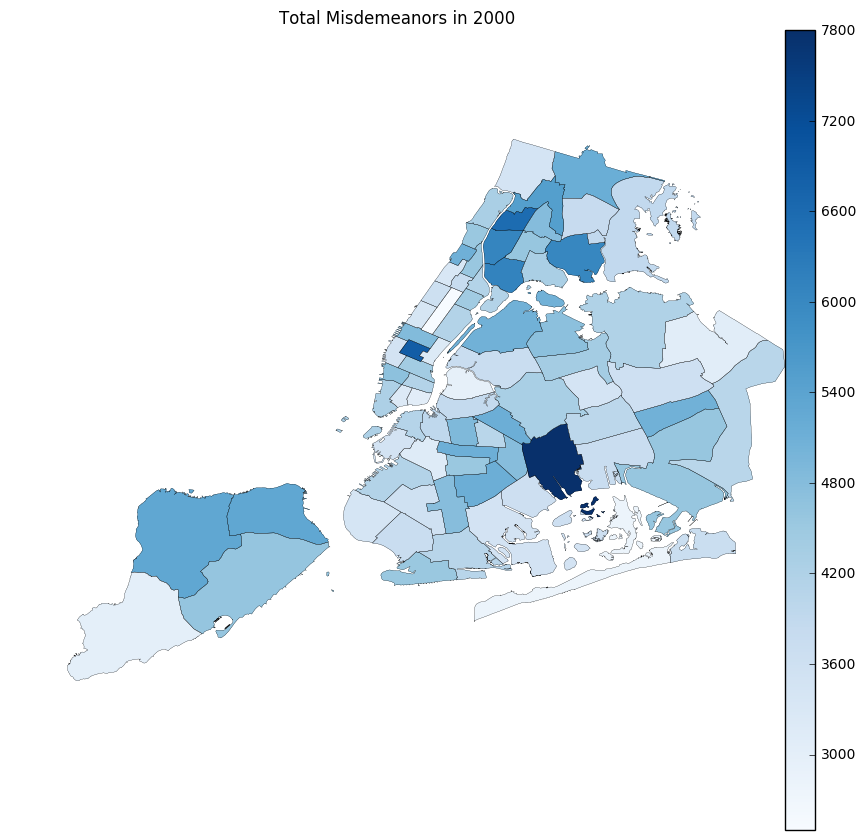

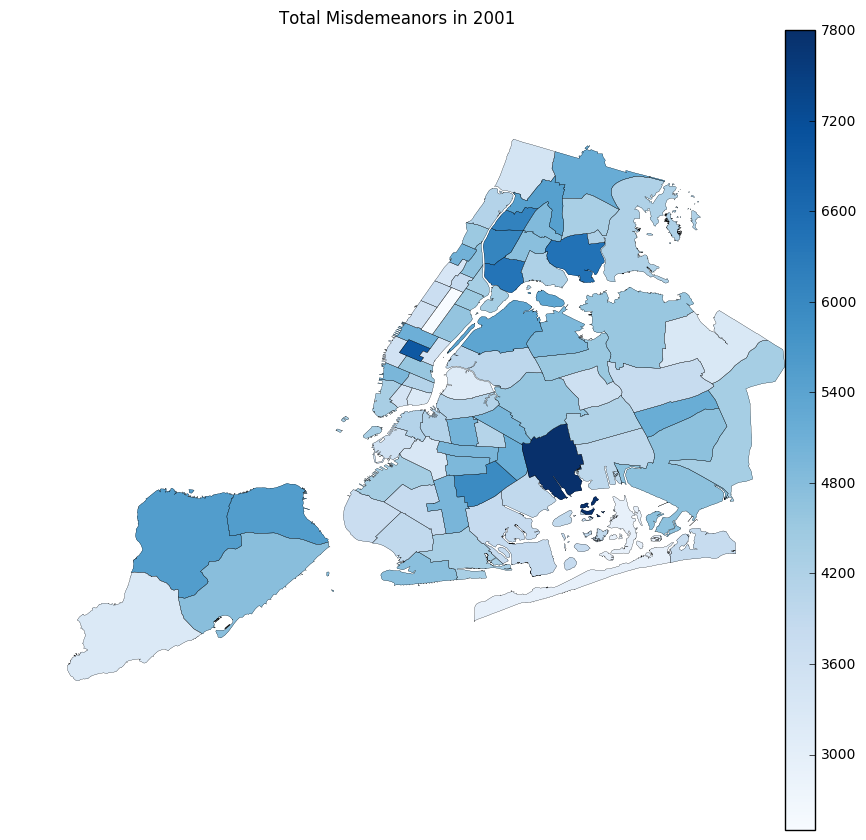

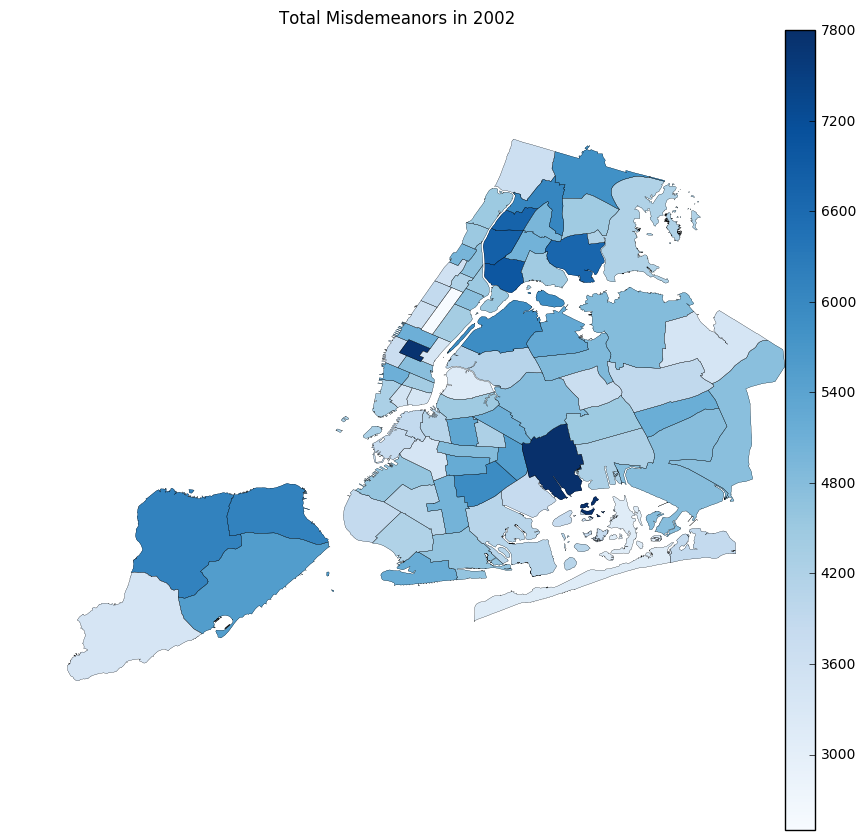

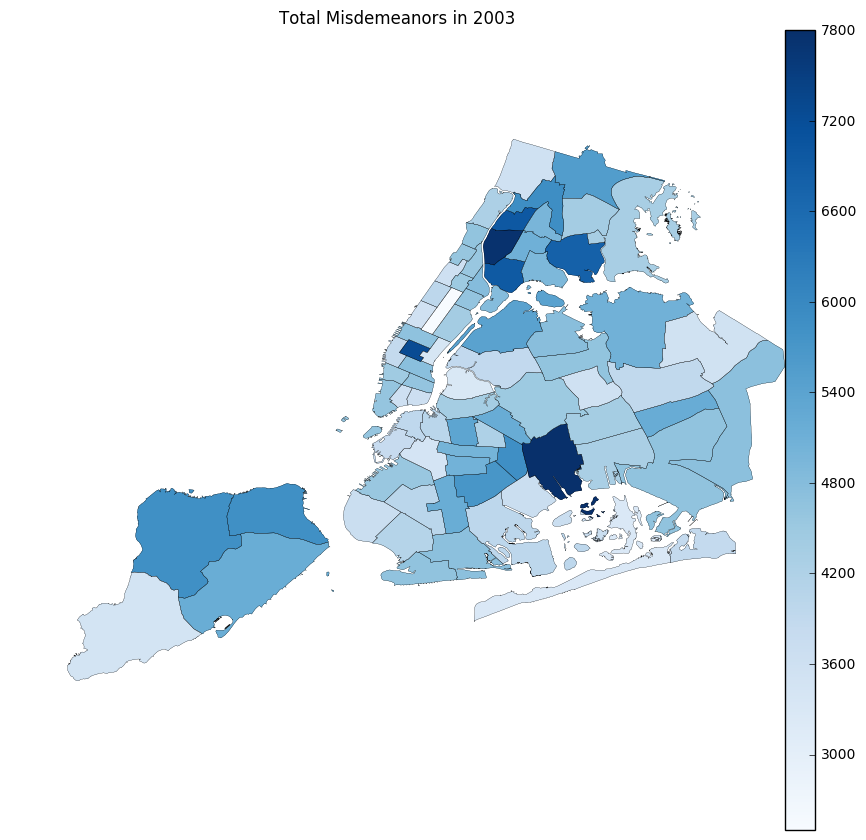

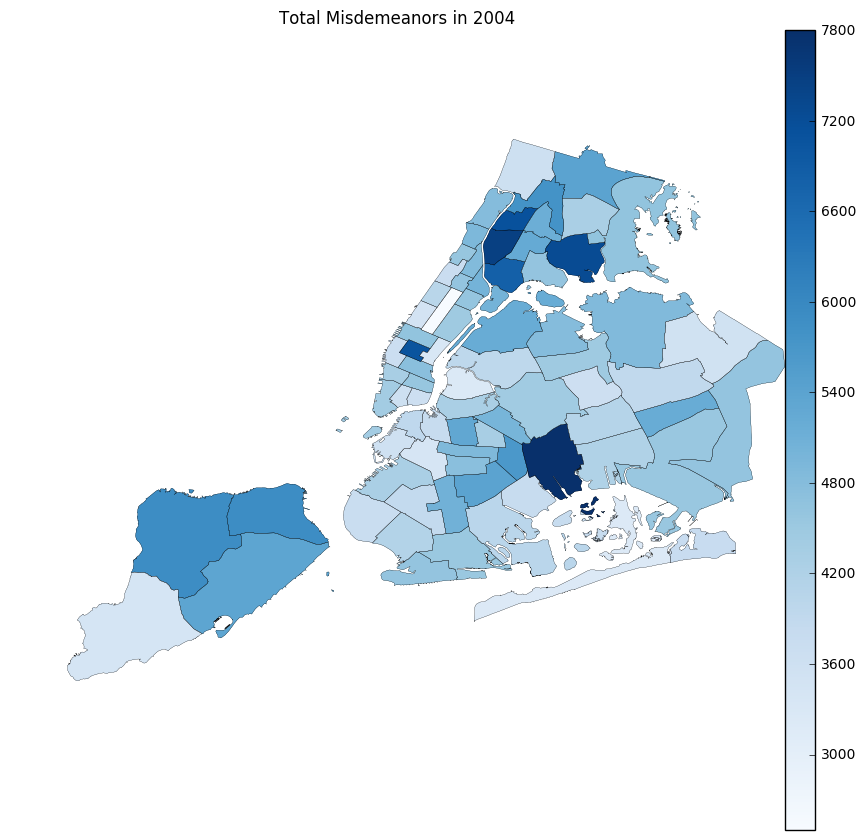

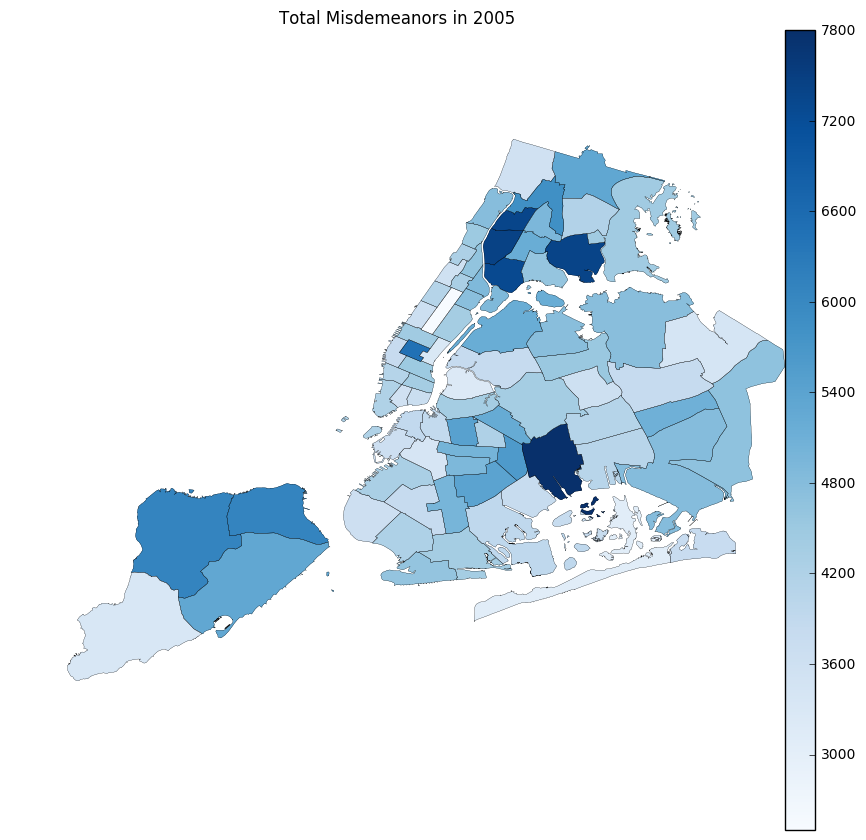

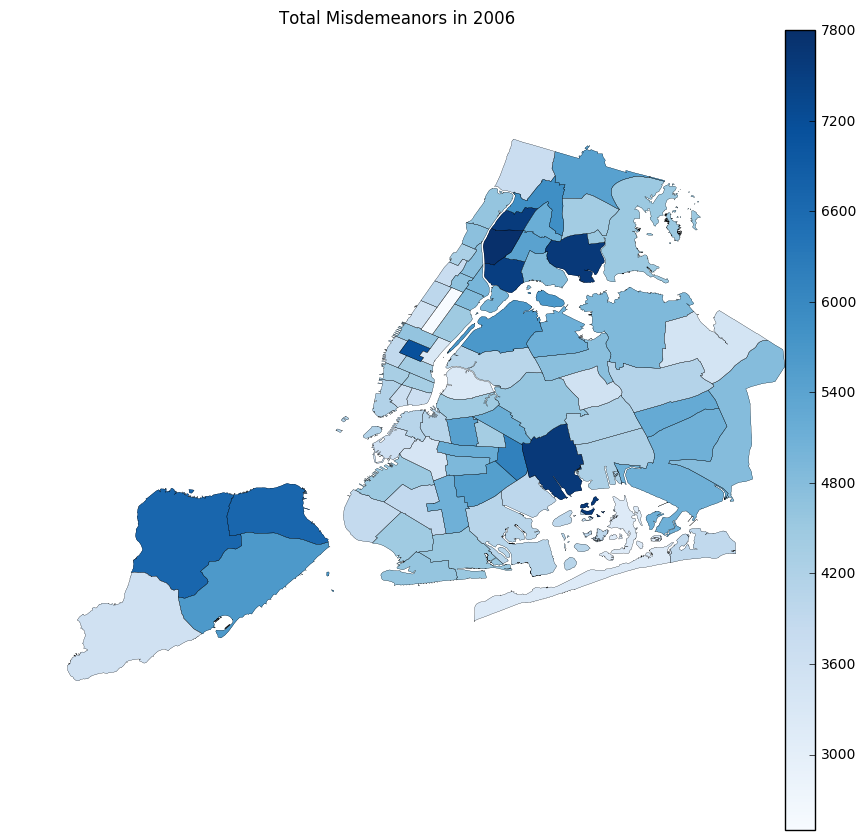

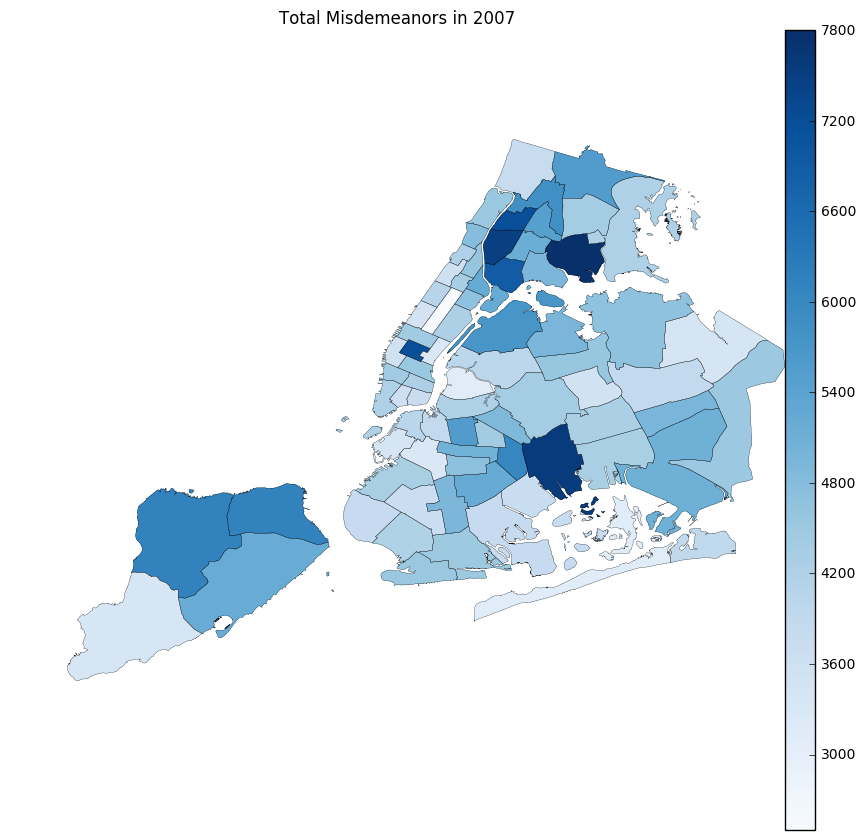

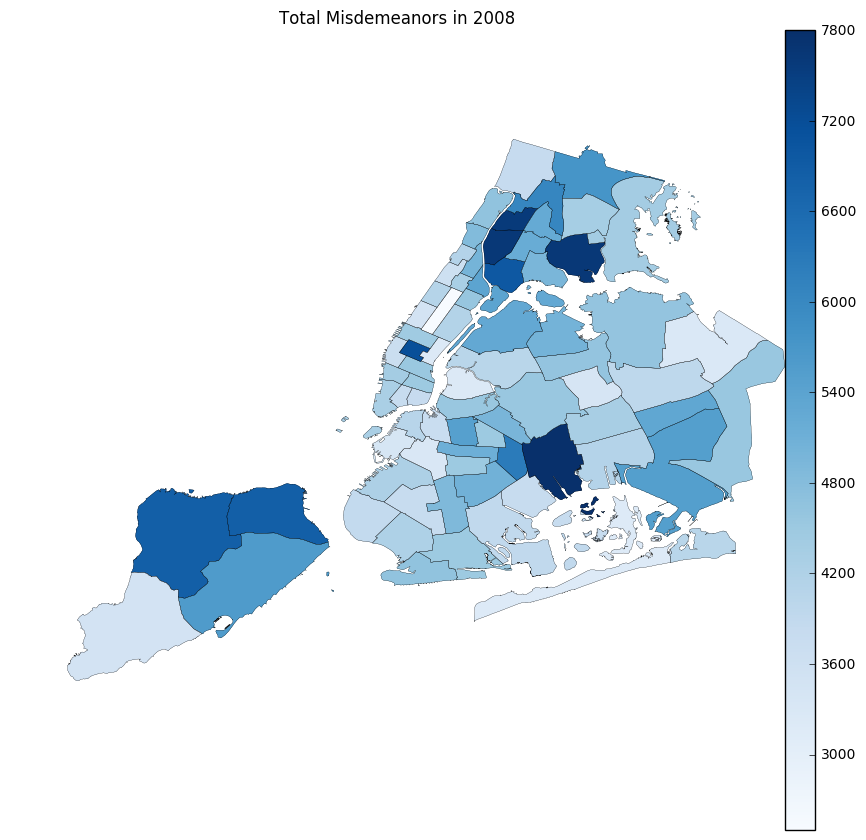

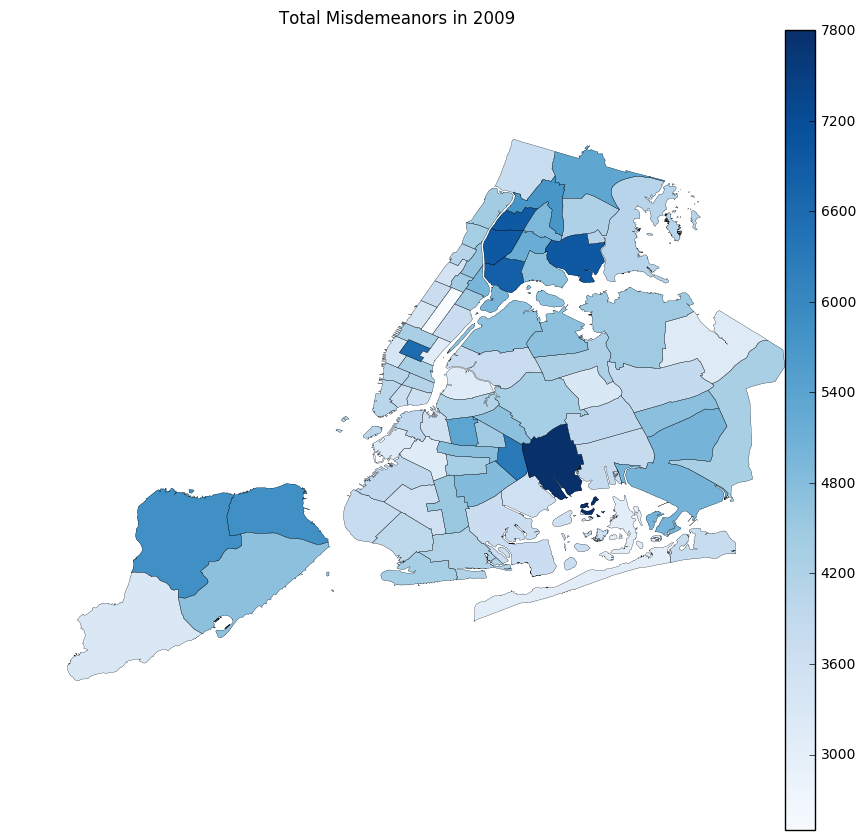

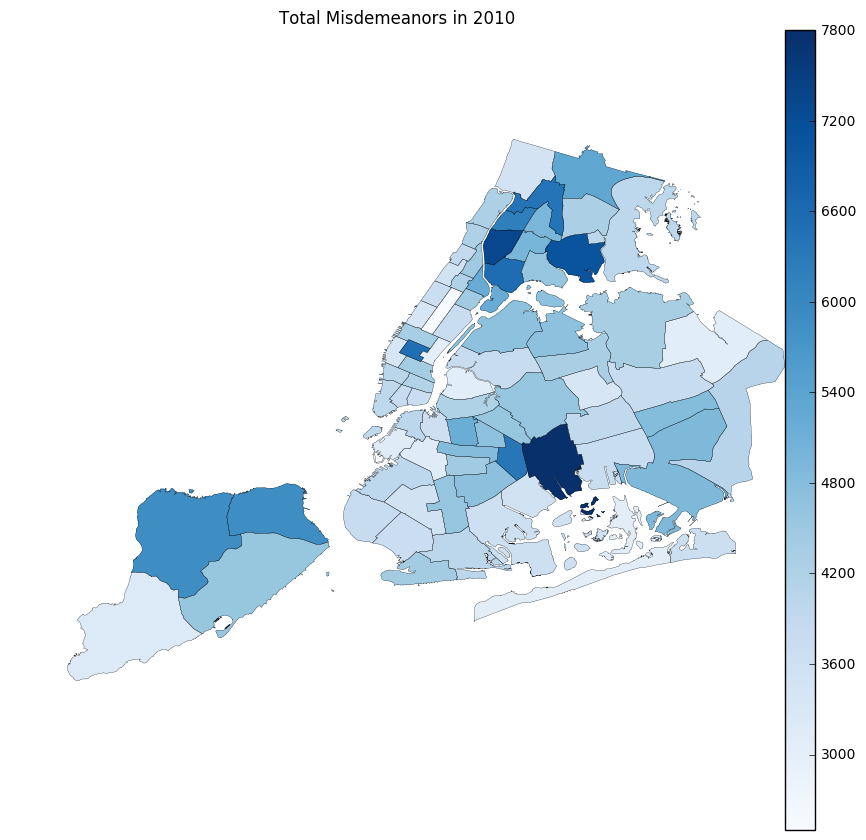

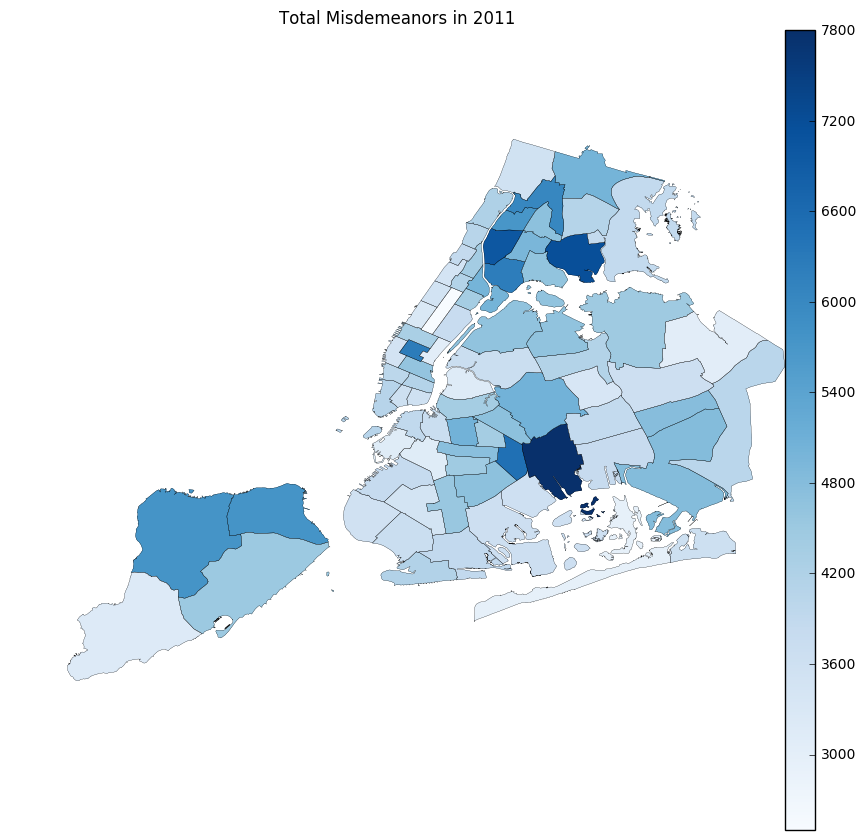

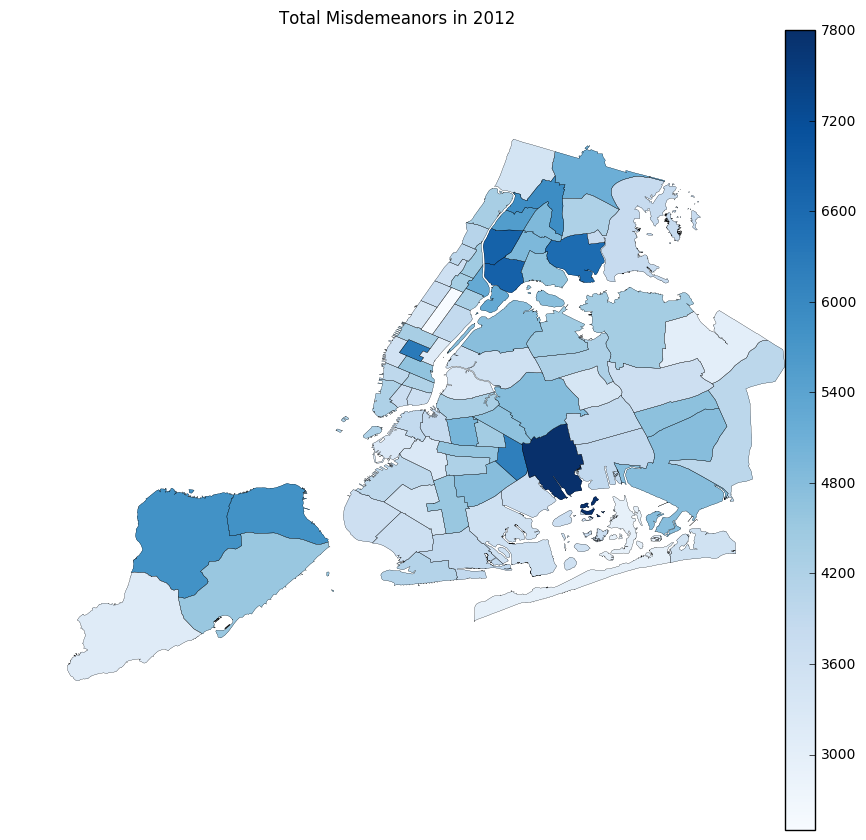

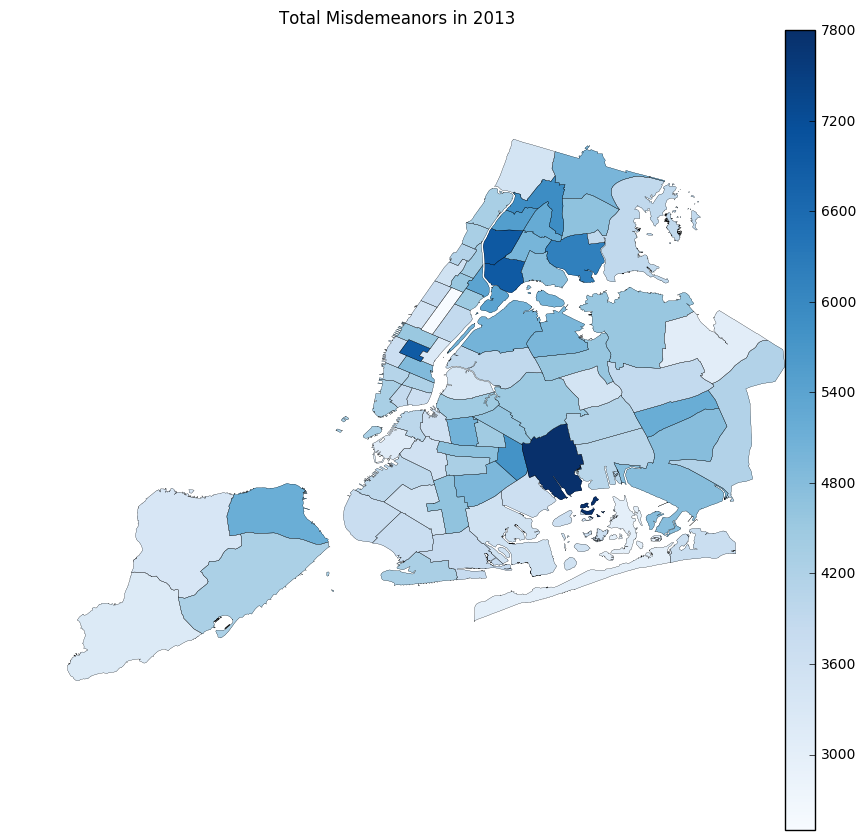

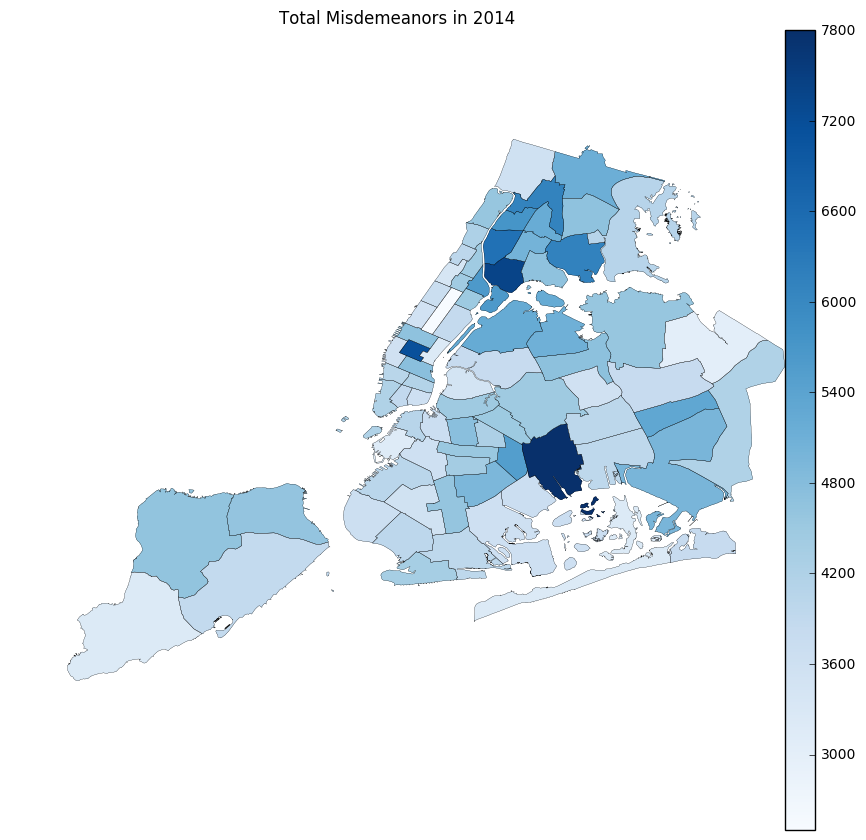

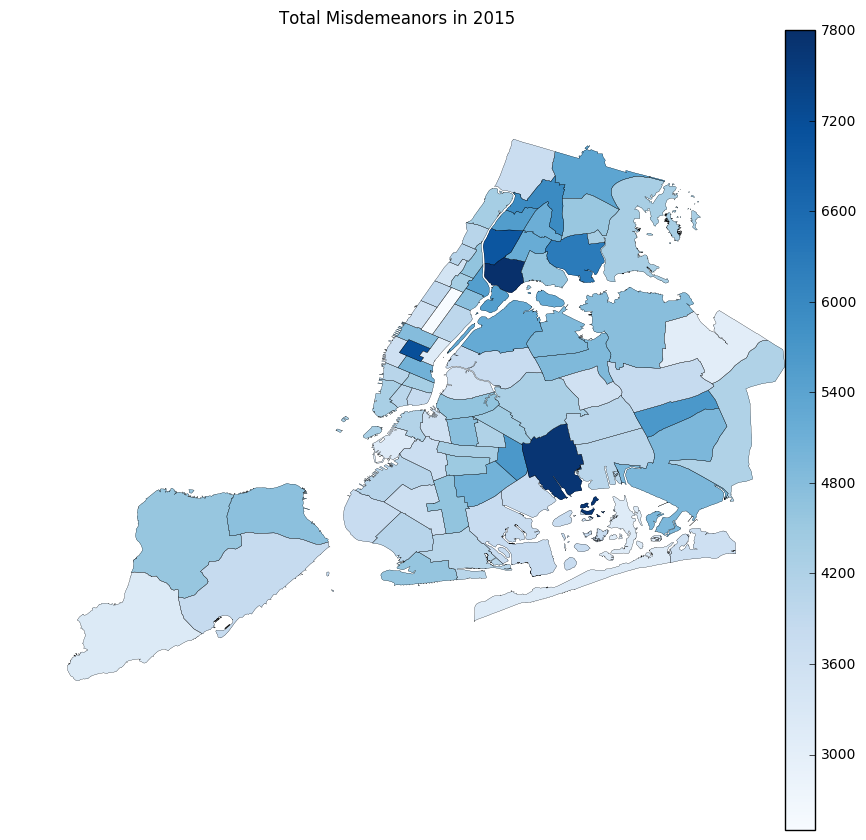

In [15]:
#Saving chloropleths as image files to write to gif (see notebook titled "Gif_Writing")
year = np.arange(2000,2016)
year = year.astype('str')
images = []
for i in year: 
    f, ax = plt.subplots(figsize=(10,10))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    tot_crime.plot(column=i,colormap='Blues',alpha=1,linewidth=0.1,ax=ax)
    plt.title("Total Misdemeanors in {}".format(i) )

    #cr_mean = mean(tot_crime['2000'])
    #stdev= std(tot_crime['2000'])
    ax = tot_crime.plot(column=i, colormap='Blues',alpha = 1, linewidth=0.1, axes=ax)
    vmin, vmax = (2500), (7800)

    ax.axis('off')
    fig = ax.get_figure()
    cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    fig.colorbar(sm, cax=cax)

    pl.savefig("{}.png".format(i))